# Analysis notebook for: How much research shared on Facebook is hidden from public view?

This notebook produces all results and figures in the article.

Figures are plotted to the *figures/* directory.

In order to re-produce the plots without interacting with the notebook use `jupyter nbconvert --execute analysis.ipynb`

**Outline**



In [2]:
from pathlib import Path

import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2, venn3, venn3_circles
from oauth2client.service_account import ServiceAccountCredentials
from scipy import stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

tqdm.pandas()

In [3]:
# Implementation of partial log binning following Milojević (2010)
def thresh(bin_size):
    x = 1
    while True:
        diff = np.log10(x+1) - np.log10(x)
        if diff < bin_size:
            return x +1
        x = x + 1

def partial_log_binning(data_counts, bin_size=0.1):
    n_bins = 1/bin_size
    binning_threshold = thresh(bin_size)

    log_data = np.log10(data_counts)
    log_index = np.log10(log_data.index)

    logbins = np.linspace(np.log10(binning_threshold)+0.1,
                          np.log10(max(data)),
                          ((np.log10(max(data))-np.log10(binning_threshold)+0.1)//0.1)+1)

    binned_xs = []
    binned_vals = []      
    
    for i in range(1, binning_threshold+1):      
        if i in log_data.index:
            binned_vals.append(log_data.loc[i])
            binned_xs.append(np.log10(i))
    
    for b in logbins:       
            vals = (b-.05 <= log_index) & (log_index < b+.05)
            vs = data_counts[vals]
            if len(vs)>0:
                n = np.ceil(10**(b+.05) - 10**(b-.05))
                if n == 0:
                    continue
                binned_vals.append(np.log10(vs.sum()/n))
                binned_xs.append(b)
    return binned_xs, binned_vals  

# Configuration

In [4]:
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Seaborn styles
sns.set_style("whitegrid")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

In [5]:
### Optional ###
# Set up GSpread connection to push dataframes to Google Spreadsheets
# Instructions can be found at https://gspread.readthedocs.io/en/latest/

# scope = ['https://spreadsheets.google.com/feeds',
#          'https://www.googleapis.com/auth/drive']

# credentials = ServiceAccountCredentials.from_json_keyfile_name('My Project-d9fa71152fe8.json', scope)

# gc = gspread.authorize(credentials)
# sh =  gc.open("PLOS Paper - Tables")

push_to_gspread = False

# Load data, preprocessing, dropping years + bad results

In [6]:
articles_csv = "data/articles.csv"
responses_csv = "data/responses.csv"

figs = Path("figures")

In [7]:
articles = pd.read_csv(articles_csv, index_col="doi", parse_dates=['publication_date'])
all_responses = pd.read_csv(responses_csv, index_col="id", parse_dates=['received_at', 'og_updated_time', 'publication_date', 'added_on'])

# add year and metrics
all_responses = all_responses.merge(articles[['year', 'AES', 'AER', 'AEC', 'discipline']], left_on="doi", right_index=True, how="left")

In [8]:
# Limit responses to those articles that received some forms of engagement
responses = all_responses
responses = responses.replace(0, np.nan)
responses = responses.dropna(subset=['shares', 'reactions', 'comments'], how="all")

In [9]:
all_shares = set(articles['AES'].dropna().index.tolist())
all_reactions = set(articles['AER'].dropna().index.tolist())
all_comments = set(articles['AEC'].dropna().index.tolist())

any_engagement = all_shares.union(all_reactions).union(all_comments)

In [10]:
metrics = ['AES', 'AER', 'AEC']

## Methods

In [11]:
df = pd.DataFrame(columns=["Count"])
df.loc['Number of articles', "Count"] = len(articles)
df.loc['Number of URLs', "Count"] = len(articles) * 10
df.loc['--------', "Count"] = None
df.loc['Number of successful responses', "Count"] = len(all_responses)
df.loc['Number of non-zero responses', "Count"] = len(responses)
df.loc['Number of zero-responses', "Count"] = len(all_responses) - len(responses)
df.loc['---------', "Count"] = None
df.loc['Number of unique URLs', "Count"] = responses.url.nunique()
df.loc['Number of unique queries', "Count"] = responses.query_id.nunique()
df.loc['Number of unique OG IDs', "Count"] = responses.og_id.nunique()
df.loc['Number of unique DOIs', "Count"] = responses.doi.nunique()

df

,Count
Number of articles,61848.0
Number of URLs,618480.0
--------,NaN
Number of successful responses,69948.0
Number of non-zero responses,32887.0
Number of zero-responses,37061.0
---------,NaN
Number of unique URLs,32887.0
Number of unique queries,32887.0
Number of unique OG IDs,22215.0


In [12]:
articles[metrics].describe().round(2)

,AES,AER,AEC
count,21415.00,13825.00,10259.00
mean,8.81,53.54,23.99
std,136.32,475.45,311.97
min,1.00,1.00,1.00
25%,1.00,4.00,2.00
50%,2.00,16.00,6.00
75%,4.00,46.00,15.00
max,12473.00,36030.00,15840.00


## Results

### What is the overall coverage of articles?

In [13]:
temp = articles[metrics].dropna(how="all")
df = articles[metrics].count().to_frame("n")
df["% (n={})".format(len(articles))] = df['n'].div(len(articles)/100).round(2)
df['% (n={})'.format(len(temp))] = df['n'].div(len(temp)/100).round(2)
df

,n,% (n=61848),% (n=21674)
AES,21415,34.63,98.81
AER,13825,22.35,63.79
AEC,10259,16.59,47.33


### Distribution of articles with shares, reactions, and comments

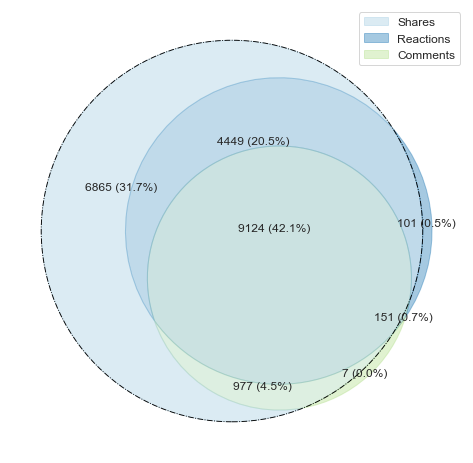

In [14]:
v = venn3(subsets= [all_shares, all_reactions, all_comments],
          set_labels=('', '', ''),
          subset_label_formatter=lambda x: "{} ({:.1f}%)".format(x, 100*x/len(any_engagement)));

c=venn3_circles(subsets= [all_shares, all_reactions, all_comments], linewidth=0)
c[0].set_lw(.9)
c[0].set_ls('-.')

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('010').set_color(cp3[1])
v.get_patch_by_id('001').set_color(cp3[2])

v.get_patch_by_id('110').set_color(np.add(cp3[0],cp3[1])/2)
v.get_patch_by_id('011').set_color(np.add(cp3[1],cp3[2])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0],cp3[2])/2)

v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1],cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(12)
for text in v.subset_labels:
    text.set_fontsize(14)


for text in v.set_labels:
    text.set_fontsize(10)
for text in v.subset_labels:
    text.set_fontsize(12)

plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
                 labels=["Shares", "Reactions", "Comments"], prop={'size': 12});

### What does the breakdown of URLs per article look like?

In [15]:
cov_urls_counts = responses[['doi', 'og_id']].groupby("doi").count().og_id.value_counts().reset_index()
cov_urls_counts['%'] = 100 * cov_urls_counts.og_id.div(cov_urls_counts.og_id.sum())
cov_urls_counts.columns = ["Number of URLs", "Articles", "Articles [%]"]

cov_urls_counts = cov_urls_counts.set_index("Number of URLs")

if push_to_gspread:
    wks = sh.worksheet("Coverage - Number of URLs")
    set_with_dataframe(wks, cov_urls_counts.round(1).reset_index())

cov_urls_counts.round(1)

,Articles,Articles [%]
Number of URLs,,
1,12344,57.0
2,7702,35.5
3,1442,6.7
4,142,0.7
5,29,0.1
6,8,0.0
7,4,0.0
8,3,0.0


In [16]:
x = responses[['doi', 'og_id']].groupby("doi").nunique().og_id.value_counts().reset_index()
x['%'] = 100*x.og_id.div(x.og_id.sum())
x.columns = ["Objects per Article", "Articles", "Articles [%]"]
x = x.set_index("Objects per Article")
x.round(1)

,Articles,Articles [%]
Objects per Article,,
1,21134,97.5
2,539,2.5
3,1,0.0


### Which URLs were used to share articles?

In [17]:
cov_urls_types = responses.type.value_counts().reset_index()
cov_urls_types['%'] = 100*cov_urls_types.type.div(cov_urls_types.type.sum())
cov_urls_types.columns = ["URL Type", "FB Objects", "FB Objects [%]"]

cov_urls_types = cov_urls_types.set_index("URL Type")

if push_to_gspread:
    wks = sh.worksheet("Coverage - URL Types")
    set_with_dataframe(wks, cov_urls_types.round(1).reset_index())

cov_urls_types.round(1)

,FB Objects,FB Objects [%]
URL Type,,
landing,21515,65.4
doi_old,4927,15.0
metrics,4348,13.2
doi,982,3.0
pdf,644,2.0
authors,296,0.9
related,96,0.3
comments,76,0.2
pmid,2,0.0


In [18]:
# Number of FB objects per DOI
n_responses_per_doi = responses[['doi', 'og_id']].groupby("doi")["og_id"].nunique()

# DOIs with multiple FB objects
dois_with_mult_ogids = n_responses_per_doi[n_responses_per_doi>1].keys()

# Responses of DOIs with more FB objects
y = responses[responses.doi.isin(dois_with_mult_ogids)]

# URL types of those articles with more than one response
z = y[['doi', 'og_id', 'type']].groupby(["doi", "og_id"])['type'].apply(lambda x: ", ".join(sorted(x))).reset_index()

# Concat URL type names
zz = z.groupby("doi")['type'].apply(lambda x: " -- ".join(sorted(x)))
zz.value_counts().head(10).to_frame("Articles")

,Articles
landing -- pdf,231
"doi_old, landing -- pdf",91
"doi, landing -- pdf",58
doi_old -- landing,24
"doi, doi_old, landing -- pdf",22
"landing, metrics -- pdf",18
"doi_old, landing, metrics -- pdf",14
"authors, doi, landing -- pdf",11
"authors, doi_old, landing -- pdf",6
"doi_old -- landing, metrics",5


In [19]:
# Number of articles where a PDF caused an extra FB object
zz.map(lambda x: "pdf" in x).sum()

504

### Did the type of shared URLs change across years?

In [20]:
df = responses.groupby(['type', 'year']).size().to_frame('size').reset_index()
df = df.pivot(columns="year", index="type", values="size")
df = df.apply(lambda x: 100*x/x.sum()).sort_values(by=2017, ascending=False)

df.round(1)

year,2015,2016,2017
type,,,
landing,57.6,68.9,76.5
doi_old,15.5,19.8,7.5
doi,1.4,2.1,7.3
pdf,0.6,1.5,5.4
authors,0.3,1.2,1.7
comments,0.1,0.2,0.6
related,0.1,0.4,0.6
metrics,24.3,6.0,0.5
pmc,0.0,NaN,NaN


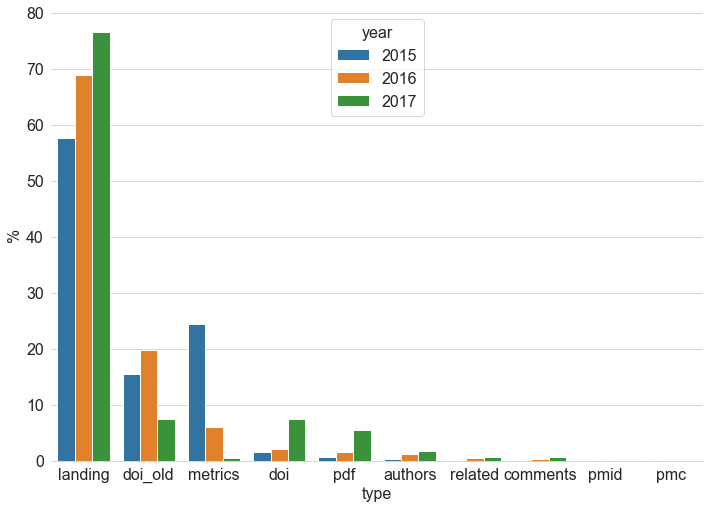

In [21]:
df = responses.groupby(['type', 'year']).size().to_frame('size').reset_index()

sort_order = df.groupby("type")['size'].sum().sort_values(ascending=False).index.tolist()
year_counts = df.groupby("year")['size'].sum()

df['%'] = df.apply(lambda x: 100*x['size']/(year_counts[x['year']]), axis=1)


sns.barplot(x="type", y="%", hue="year", data=df, order=sort_order)
sns.despine(left=True, right=True, top=True)

### Do the types of shared URLs vary across disciplines?

In [22]:
url_types_by_disc = responses.groupby(["discipline", "type"])['og_id'].count()
url_types_by_disc = url_types_by_disc.reset_index().pivot(columns="type", index="discipline", values="og_id")
url_types_by_disc = url_types_by_disc.apply(lambda x: x.div(x.sum()), axis=1)
url_types_by_disc.round(2)

type,authors,comments,doi,doi_old,landing,metrics,pdf,pmc,pmid,related
discipline,,,,,,,,,,
Arts,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
Biology,0.01,0.00,0.03,0.17,0.63,0.13,0.02,NaN,NaN,0.00
Biomedical Research,0.01,0.00,0.02,0.15,0.67,0.14,0.01,NaN,0.0,0.00
Chemistry,0.05,0.01,0.02,0.17,0.63,0.11,0.02,NaN,NaN,0.01
Clinical Medicine,0.01,0.00,0.03,0.13,0.68,0.13,0.02,0.0,0.0,0.00
Earth and Space,0.02,0.00,0.04,0.20,0.58,0.13,0.02,NaN,NaN,0.00
Engineering and Technology,0.01,0.00,0.02,0.15,0.63,0.15,0.02,NaN,NaN,0.01
Health,0.01,0.00,0.05,0.13,0.64,0.15,0.02,NaN,NaN,0.00
Humanities,NaN,NaN,0.12,0.23,0.46,0.15,0.04,NaN,NaN,NaN


In [23]:
url_types_by_disc = url_types_by_disc.rank(method="min", ascending=False, axis=1).sort_values(axis=1, by="Clinical Medicine")
url_types_by_disc

type,landing,doi_old,metrics,doi,pdf,authors,related,comments,pmc,pmid
discipline,,,,,,,,,,
Arts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Biology,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,NaN,NaN
Biomedical Research,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,NaN,9.0
Chemistry,1.0,2.0,3.0,5.0,6.0,4.0,7.0,7.0,NaN,NaN
Clinical Medicine,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9.0
Earth and Space,1.0,2.0,3.0,4.0,5.0,6.0,8.0,7.0,NaN,NaN
Engineering and Technology,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,NaN,NaN
Health,1.0,3.0,2.0,4.0,5.0,6.0,7.0,7.0,NaN,NaN
Humanities,1.0,2.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN


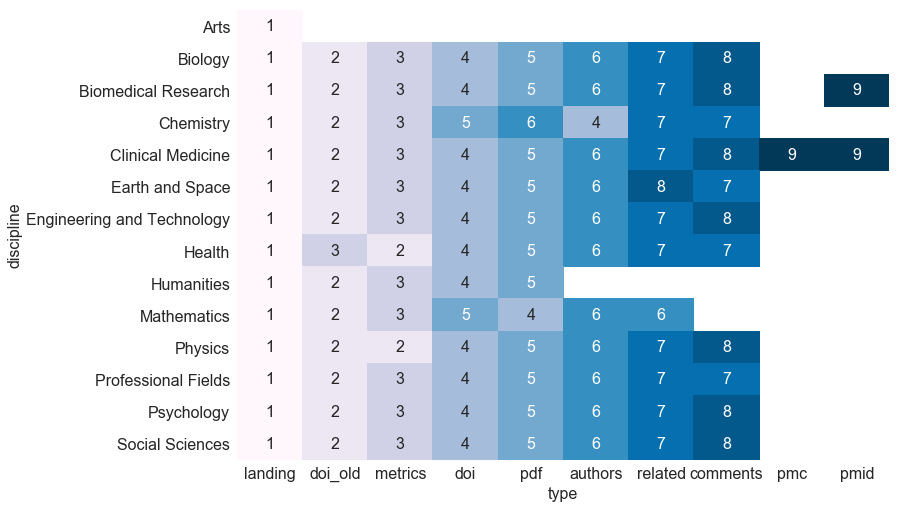

In [24]:
sns.heatmap(url_types_by_disc, cmap="PuBu", annot=True, cbar=False)

### What kind of engagement did the articles receive?

In [25]:
articles[metrics].describe()

,AES,AER,AEC
count,21415.000000,13825.000000,10259.000000
mean,8.811674,53.535335,23.989668
std,136.323191,475.446702,311.972031
min,1.000000,1.000000,1.000000
25%,1.000000,4.000000,2.000000
50%,2.000000,16.000000,6.000000
75%,4.000000,46.000000,15.000000
max,12473.000000,36030.000000,15840.000000


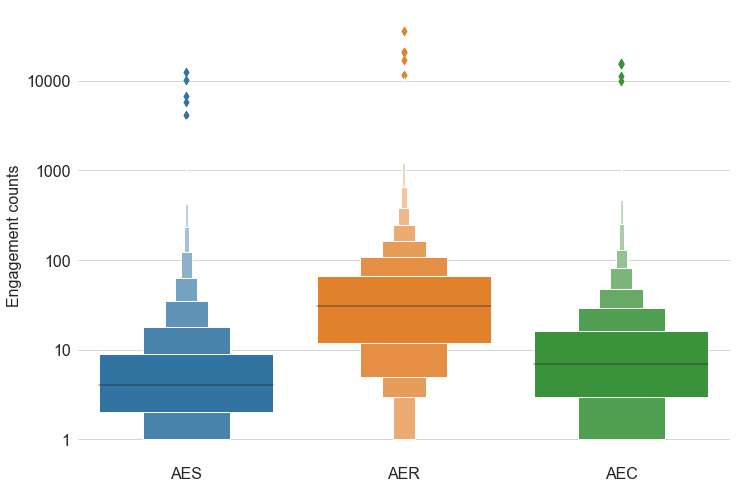

In [33]:
pdf = articles[metrics].dropna(how="any")

sns.boxenplot(x="variable", y="value", data=pdf.melt())
plt.yscale("log")

yticks = [1, 10, 100, 1000, 10000]
plt.yticks(yticks, yticks);

plt.xlabel("")
plt.ylabel("Engagement counts")

sns.despine(top=True, left=True, right=True, bottom=True)

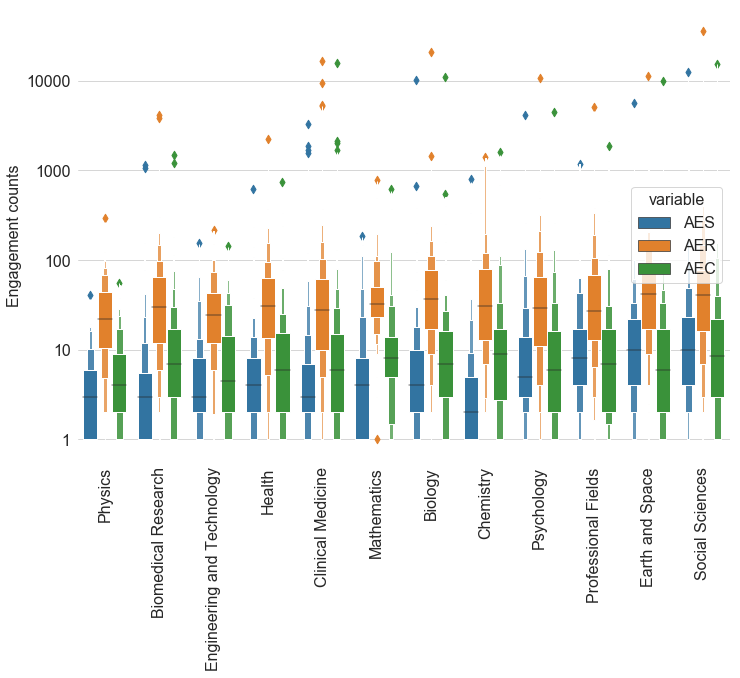

In [242]:
sort_order = base.dropna(how="any", subset=metrics).groupby("discipline").AES.mean().sort_values().keys()

pdf = base.dropna(how="any", subset=metrics)
pdf = pdf.melt(id_vars="discipline", value_vars=metrics)

sns.boxenplot(x="discipline", hue="variable", y="value", data=pdf, order=sort_order)
plt.yscale("log")

yticks = [1, 10, 100, 1000, 10000]
plt.yticks(yticks, yticks);

plt.xticks(rotation=90)

plt.xlabel("")
plt.ylabel("Engagement counts")

sns.despine(top=True, left=True, right=True, bottom=True)

In [380]:
artics = articles[(articles.AES.isna()) & ((~articles.AER.isna()) | (~articles.AEC.isna()))]
artics.describe()

,pmid,year,AES,POS,TW,AER,AEC
count,2.590000e+02,259.000000,0.0,60.000000,202.000000,252.000000,158.000000
mean,2.616453e+07,2015.270270,NaN,1.266667,4.707921,23.214286,9.139241
std,7.057507e+05,0.524889,NaN,0.482461,5.467119,29.256417,9.666719
min,2.563409e+07,2015.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,2.576836e+07,2015.000000,NaN,1.000000,1.000000,4.000000,2.000000
50%,2.581630e+07,2015.000000,NaN,1.000000,3.000000,12.000000,6.000000
75%,2.603203e+07,2015.000000,NaN,1.250000,5.000000,30.000000,12.000000
max,2.874286e+07,2017.000000,NaN,3.000000,34.000000,159.000000,56.000000


#### Do the shared URL types receive different kinds of engagement?

### Analysis by groups: Do all articles receive the same types of engagement?

In [95]:
from itertools import product 

def select_nonzero_src(df: pd.DataFrame, s: bool, r: bool, c: bool) -> pd.DataFrame:
    bdf = df.isna()
    return df[(bdf.AES != s) & (bdf.AER != r) & (bdf.AEC != c)]

In [ ]:
df_src = base[(~base.AES.isna()) & (~base.AER.isna()) & (~base.AEC.isna())]
df_sr = base[(~base.AES.isna()) & (base.AER.isna()) & (~base.AEC.isna())]
df_sc = base[(~base.AES.isna()) & (~base.AER.isna()) & (base.AEC.isna())]
df_s = base[(~base.AES.isna()) & (base.AER.isna()) & (base.AEC.isna())]
df_rc = base[(base.AES.isna()) & ((~base.AER.isna()) | (~base.AEC.isna()))]
df_ = base[(base.AES.isna()) & (base.AER.isna()) & (base.AEC.isna())]

perms = [df_src, df_sr, df_sc, df_s, df_rc, df_]
labels = ['All counts', 'Shares & Reactions', 'Shares & Comments', 'Only Shares', 'Reactions or Comments', 'None']
[print(len(_)) for _ in perms];

#### Correlations by groups

In [218]:
df = pd.DataFrame()
for tdf, l in zip(perms, labels):
    df[l] = tdf.discipline.value_counts().sort_values(ascending=False)

In [251]:
df.rank()

,All counts,Shares & Reactions,Shares & Comments,Only Shares,Reactions or Comments,None
Clinical Medicine,12.0,12.0,12.0,12.0,11.0,12.0
Biomedical Research,11.0,11.0,11.0,11.0,10.0,11.0
Biology,10.0,10.0,10.0,10.0,9.0,10.0
Psychology,9.0,9.0,9.0,9.0,8.0,8.0
Earth and Space,8.0,6.5,8.0,6.0,3.5,6.5
Social Sciences,7.0,5.0,6.0,5.0,6.0,3.0
Health,6.0,8.0,7.0,8.0,7.0,6.5
Professional Fields,5.0,3.5,3.0,4.0,1.5,2.0
Engineering and Technology,3.5,6.5,4.0,7.0,3.5,9.0
Physics,3.5,3.5,5.0,3.0,5.0,5.0


In [280]:
(df.fillna(0).apply(lambda x: 100*x/x.sum(), axis=1).sort_values(by="Clinical Medicine", axis=1, ascending=False)
     .style
     .background_gradient(axis=1, cmap="Blues")
     .format("{:,.2f}")
)

,None,Only Shares,All counts,Shares & Comments,Shares & Reactions,Reactions or Comments
Clinical Medicine,66.74,12.31,11.98,6.92,1.72,0.33
Biomedical Research,67.72,9.76,14.04,6.54,1.39,0.55
Biology,53.87,10.66,23.55,9.38,1.80,0.74
Psychology,34.92,13.27,35.34,12.91,2.74,0.83
Earth and Space,45.81,10.75,30.69,11.20,1.37,0.18
Social Sciences,28.96,14.34,40.71,13.66,1.78,0.55
Health,46.70,19.87,19.59,10.58,2.60,0.65
Professional Fields,37.13,16.46,31.43,13.08,1.69,0.21
Engineering and Technology,73.29,10.40,9.47,5.41,1.27,0.17
Physics,57.14,11.85,18.18,11.04,1.30,0.49


In [278]:
(df.T.fillna(0).apply(lambda x: 100*x/x.sum(), axis=1).sort_values(by="None", axis=1, ascending=False)
     .style
     .background_gradient(axis=1, cmap="Blues")
     .format("{:,.2f}")
)

,Clinical Medicine,Biomedical Research,Biology,Engineering and Technology,Psychology,Earth and Space,Health,Physics,Chemistry,Social Sciences,Professional Fields,Mathematics
All counts,39.04,22.38,17.68,1.24,6.60,3.74,2.34,1.24,0.44,3.31,1.65,0.32
Shares & Reactions,52.27,20.66,12.60,1.55,4.75,1.55,2.89,0.83,0.41,1.34,0.83,0.31
Shares & Comments,46.38,21.41,14.47,1.46,4.95,2.81,2.60,1.55,0.37,2.28,1.42,0.30
Only Shares,53.76,20.84,10.73,1.83,3.32,1.76,3.18,1.09,0.34,1.56,1.16,0.43
Reactions or Comments,37.07,30.50,19.31,0.77,5.41,0.77,2.70,1.16,0.00,1.54,0.39,0.39
None,53.59,26.58,9.96,2.37,1.61,1.38,1.38,0.96,0.70,0.58,0.48,0.43


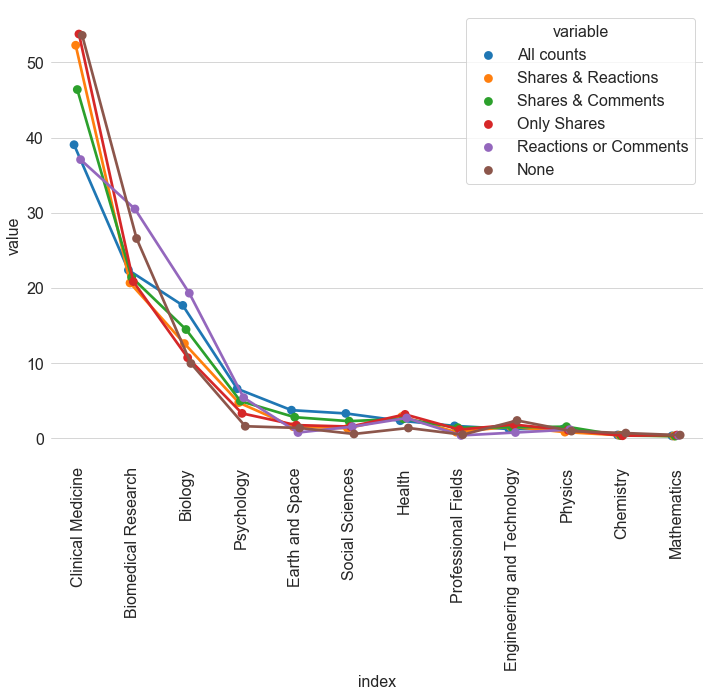

In [222]:
pdf = df.apply(lambda x: 100*x/x.sum())
sort_order = pdf.index.tolist()

pdf = pdf.reset_index().melt(id_vars="index")
ax = sns.pointplot(x="index", y="value", hue="variable", data=pdf, order=sort_order, dodge=True)

# # Line for all articles with 1 share
# pdf = base[base.AES==1].discipline.value_counts().to_frame()
# pdf = pdf.apply(lambda x: 100*x/x.sum())
# sns.pointplot(x="index", y="discipline", data=pdf.reset_index(), markers="X", color="red", linestyle="--", ax=ax)

plt.xticks(rotation=90)
sns.despine(top=True, left=True, right=True, bottom=True)

# Comparison of retrieval methods

In [40]:
# Remove articles in Arts and Humanities
base = articles[~articles.discipline.isin(["Arts", "Humanities"])]
"Removed {} articles in Arts or Humanities".format(articles[articles.discipline.isin(["Arts", "Humanities"])].shape[0])

# Unit of analysis
disc = 'discipline'

### Coverage of Shares, Reactions, and Comments

In [35]:
print(articles[['AES', 'AER', 'AEC']].dropna(how="all").shape[0])
articles.describe()

21674


,pmid,year,AES,POS,TW,AER,AEC
count,6.184300e+04,61848.000000,21415.000000,9623.000000,43064.000000,13825.000000,10259.000000
mean,2.721320e+07,2015.873642,8.811674,2.301465,8.923718,53.535335,23.989668
std,1.080284e+06,0.824578,136.323191,4.804324,63.637819,475.446702,311.972031
min,2.555500e+07,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.624747e+07,2015.000000,1.000000,1.000000,1.000000,4.000000,2.000000
50%,2.701101e+07,2016.000000,2.000000,1.000000,3.000000,16.000000,6.000000
75%,2.815831e+07,2017.000000,4.000000,2.000000,6.000000,46.000000,15.000000
max,2.928712e+07,2017.000000,12473.000000,186.000000,8626.000000,36030.000000,15840.000000


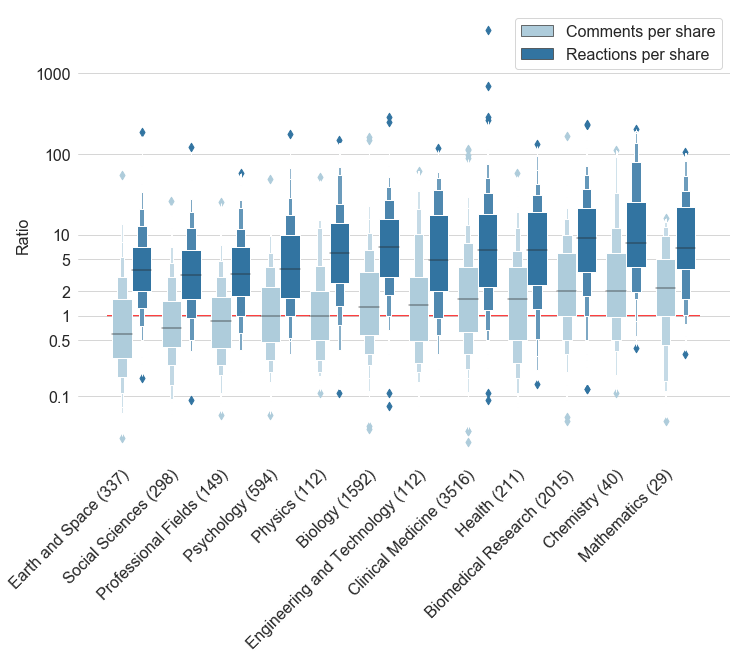

In [61]:
disc_counts = base.dropna(how="any", subset=['AES', 'AER', 'AEC'])[disc].value_counts()

x = base.dropna(how="any", subset=['AES', 'AER', 'AEC'])[[disc, 'AES', 'AER', 'AEC']]
x['Reactions per share'] = x['AER'] / x['AES']
x['Comments per share'] = x['AEC'] / x['AES']
x = x.melt(id_vars=disc, value_vars=['Comments per share', 'Reactions per share']).dropna()

meds = x.groupby(["discipline", "variable"])['value'].median().reset_index().groupby(disc)['variable', 'value'].apply(lambda x: x.iloc[0,1])
x['sort'] = x[disc].map(lambda x: meds[x])

x[disc] = x[disc].map(lambda x: "{} ({})".format(x, disc_counts[x]))
x = x.sort_values(["sort"])

ax = sns.boxenplot(x=disc, y="value", hue="variable", data=x, palette=cm)

# Scale and axes limits
plt.yscale("log")
xmin, xmax = ax.get_xlim()

# Plot additional line
plt.hlines(1, xmin, xmax, zorder=-1, color="red")

# X and Y ticks & labels
yticks = [0.1, 0.5, 1, 2, 5, 10, 100, 1000]
plt.yticks(yticks, yticks);

plt.xticks(rotation=45, ha="right");

# Axes labels
plt.xlabel("")
plt.ylabel("Ratio")

# Remove legend title
l = ax.legend()
l.set_title(None)

sns.despine(left=True, right=True, top=True, bottom=True)

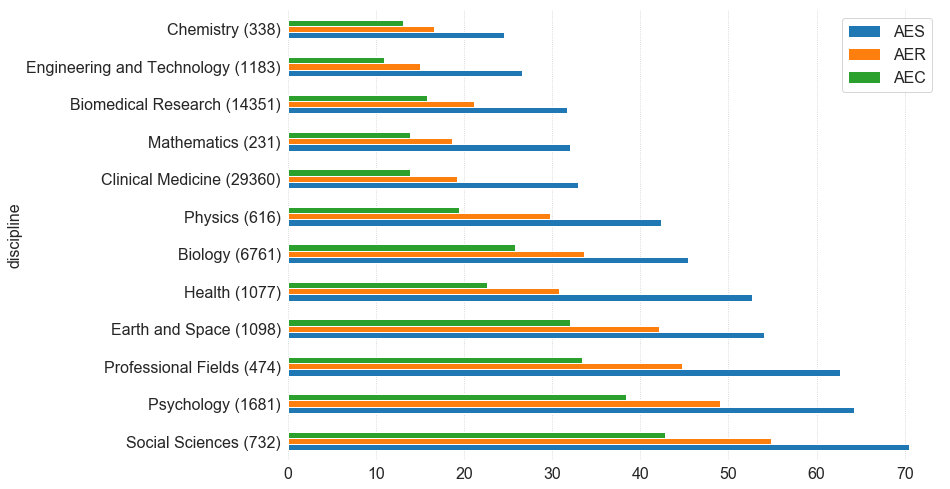

In [49]:
disc_counts = base[disc].value_counts()
x = base.groupby(disc)[['AES', 'AER', 'AEC']].count()
x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))
x.sort_values("AES", ascending=False).plot(kind="barh")

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

In [1]:
disc_counts = base.disc.value_counts()
x = base.groupby("disc")[['AES', 'AER', 'AEC']].count()
# x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))

x['AER/AES'] = 100 * x['AER'] / x['AES']
x['AEC/AES'] = 100 * x['AEC'] / x['AES']
x[['AER/AES', 'AEC/AES']].sort_values('AEC/AES', ascending=False).plot(kind="barh")

plt.ylabel("")
ticks = list(range(0, 81, 10))
plt.xticks(ticks, ["{:,}%".format(int(_)) for _ in ticks])

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

NameError: name 'base' is not defined

In [29]:
col = "disc"

cov_disciplines = base.groupby(col)[metrics].apply(lambda x: x.count())
cov_disciplines['All articles'] = base.groupby(col)[metrics].size()
cov_disciplines = cov_disciplines.sort_values("All articles", ascending=False)

# Column names + order
cov_disciplines.index.name = "Discipline"

##### Distribution of disciplines

##### Detailed look at Facebook

In [145]:
any_fb_counts = base.reindex(all_shares.union(am_shares))[col].value_counts()
any_fb_counts.loc['Total'] = any_fb_counts.sum()

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


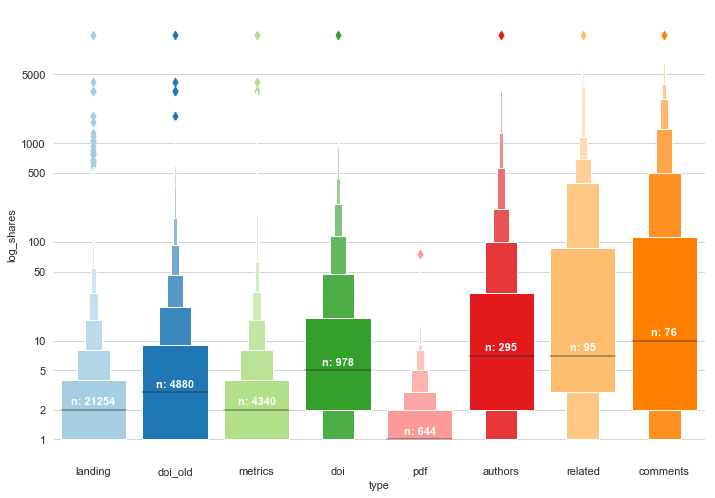

In [226]:
mask = nz_resp['type'].isin(["pmc", "pmid"])
pdf = nz_resp[~mask]
pdf['log_shares'] = pdf['shares'].map(lambda x: np.log10(x))

order = pdf.type.value_counts().keys().tolist()

ax = sns.boxenplot(x="type", y="log_shares", data=pdf,
                   saturation=1,
                   order=order, palette=cm)


medians = pdf.groupby(['type'])['log_shares'].median()
nobs = pdf['type'].value_counts()
nobs = nobs.map(lambda x: "n: {}".format(x))

pos = range(len(nobs))
for pos, label in enumerate(order):
    plt.text(pos, medians[label]+.05, nobs[label],
             horizontalalignment='center', color='w', weight='semibold')

ticks = [1, 2, 5, 10, 50, 100, 500, 1000, 5000]
plt.yticks(np.log10(ticks), ticks);

sns.despine(left=True, right=True, top=True, bottom=True);

# References

Milojević, S. (2010). Power law distributions in information science: Making the case for logarithmic binning. Journal of the American Society for Information Science and Technology, 61(12), 2417–2425. doi: 10/bm7ck6